In [1]:
import os
import numpy as np
import scanpy as sc
import anndata as ad
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(5, 5)
plt.rcParams['figure.dpi'] = 200
sc.settings.verbosity = 3
sc.logging.print_versions()
#results_file = './write/results.h5ad'


%load_ext autoreload
%autoreload 2 

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.4 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.22 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


In [2]:
import rpy2.rinterface_lib.callbacks
import logging
import warnings
from rpy2.robjects import pandas2ri
import anndata2ri


# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [3]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)
#library(RColorBrewer)
#library(slingshot)
#library(monocle)
#library(gam)
#library(clusterExperiment)
#library(ggplot2)
#library(plyr)
library(MAST)

# Dataloading

In [4]:
! pwd

/Users/carlo.dedonno/Projects/HPA


In [5]:
adatas = []

data_file = './data/MUC10103/raw_gene_bc_matrices/mm10/matrix.mtx'
barcode_file = './data/MUC10103/raw_gene_bc_matrices/mm10/barcodes.tsv'
gene_file = './data/MUC10103/raw_gene_bc_matrices/mm10/genes.tsv'

adata = sc.read(data_file, cache=True)
adata = adata.transpose()

barcodes = pd.read_csv(barcode_file, header=None, sep='\t')
genes = pd.read_csv(gene_file, header=None, sep='\t')

#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata.obs = barcodes
adata.obs['tissue'] = 'Pituitary'
adata.obs['condition'] = 'Control'
genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata.var = genes
adatas.append(adata)

##############################################################################################
data_file = './data/MUC10104/raw_gene_bc_matrices/mm10/matrix.mtx'
barcode_file ='./data/MUC10104/raw_gene_bc_matrices/mm10/barcodes.tsv'
gene_file ='./data/MUC10104/raw_gene_bc_matrices/mm10/genes.tsv'

adata = sc.read(data_file, cache=True)
adata = adata.transpose()

barcodes = pd.read_csv(barcode_file, header=None, sep='\t')
genes = pd.read_csv(gene_file, header=None, sep='\t')

#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata.obs = barcodes
adata.obs['tissue'] = 'Pituitary'
adata.obs['condition'] = 'Stress'
genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata.var = genes
adatas.append(adata)
adata = adatas[0].concatenate(adatas[1:])
print(adata)
#adata.var['gene_id'] = adata.var['gene_id-1']
#adata.var.drop(columns = ['gene_id-1', 'gene_id-0'], inplace=True)
#adata.obs.drop(columns=['sample_id'], inplace=True)
#adata.obs_names = [c.split("-")[0] for c in adata.obs_names]
#adata.obs_names_make_unique(join='_')

del adatas

... reading from cache file cache/data-MUC10103-raw_gene_bc_matrices-mm10-matrix.h5ad
... reading from cache file cache/data-MUC10104-raw_gene_bc_matrices-mm10-matrix.h5ad


Making variable names unique for controlled concatenation.


AnnData object with n_obs × n_vars = 1474560 × 27998 
    obs: 'batch', 'condition', 'tissue'
    var: 'gene_id'


In [6]:
print(adata.obs['condition'].value_counts())
print('')

Stress     737280
Control    737280
Name: condition, dtype: int64



# QC

In [7]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

/Users/carlo.dedonno/Library/Python/3.7/lib/python/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


... storing 'condition' as categorical
... storing 'tissue' as categorical


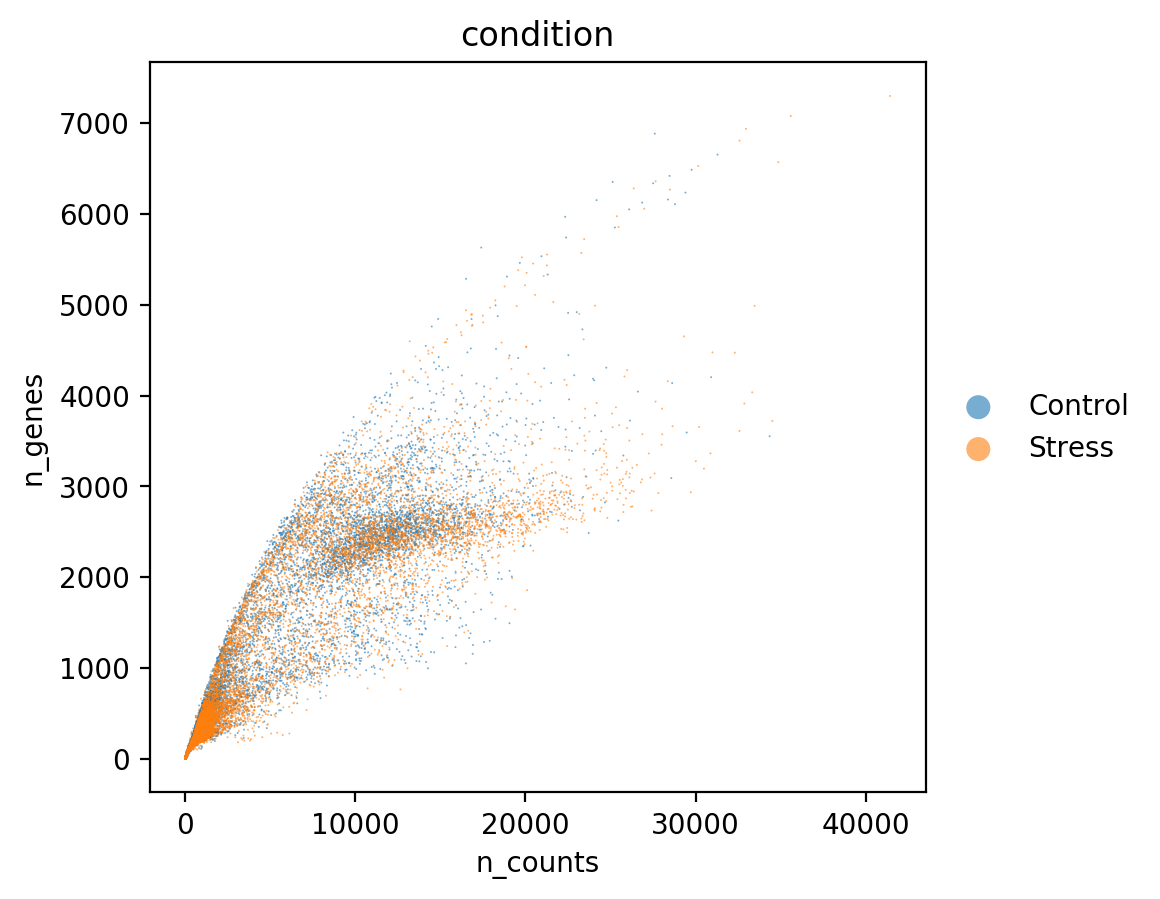

In [8]:
#Data quality summary plots
#plt.rcParams['figure.figsize'] = (10, 10)
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', size=2, color='condition', alpha=0.6)

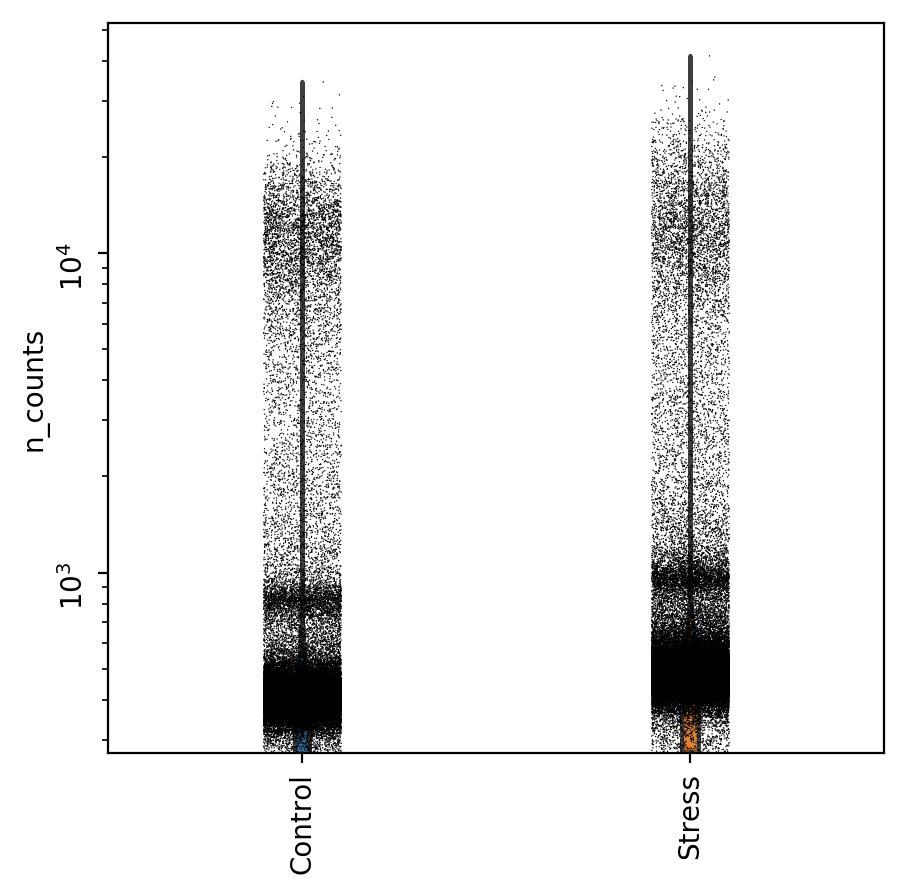

In [9]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, 'n_counts', groupby='condition', size=0.5, log=True, cut=0, rotation=90)
#t2 = sc.pl.violin(adata, 'mt_frac', groupby='sample')

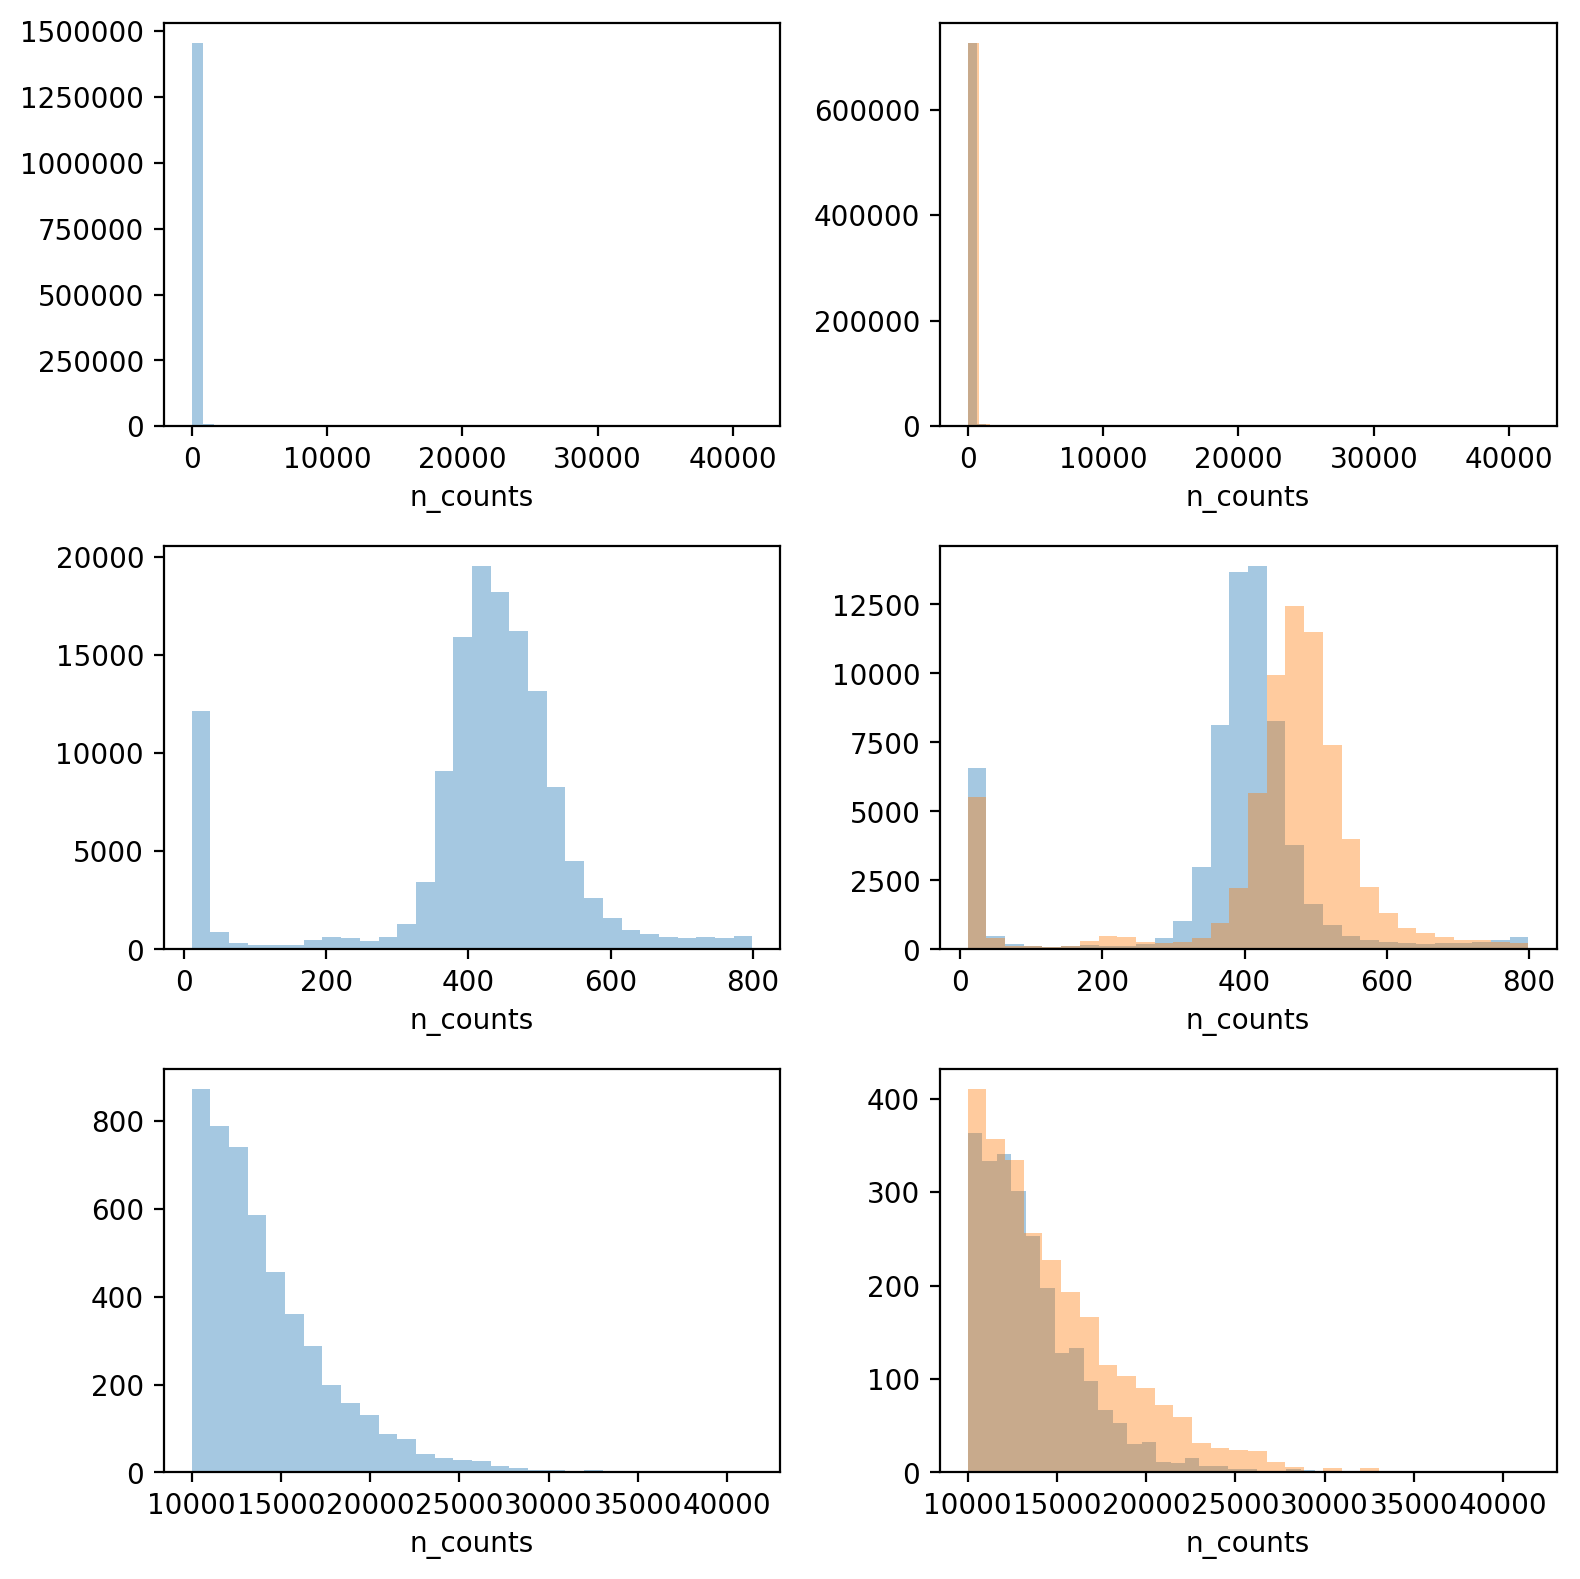

In [10]:
#Thresholding decision: counts
fig, ax = plt.subplots(3, 2, figsize=(8, 8))
sns.distplot(adata.obs['n_counts'], kde=False, ax=ax[0, 0])
sns.distplot(adata.obs['n_counts'][adata.obs['condition']=='Control'], kde=False, ax=ax[0, 1])
sns.distplot(adata.obs['n_counts'][adata.obs['condition']=='Stress'], kde=False, ax=ax[0, 1])

sns.distplot(adata.obs['n_counts'][(adata.obs['n_counts']> 10) & (adata.obs['n_counts']<800)], kde=False, bins=30, ax=ax[1, 0])
sns.distplot(adata.obs['n_counts'][adata.obs['condition']=='Control'][(adata.obs['n_counts']> 10) & (adata.obs['n_counts']<800)], kde=False, bins=30, ax=ax[1, 1])
sns.distplot(adata.obs['n_counts'][adata.obs['condition']=='Stress'][(adata.obs['n_counts']> 10) & (adata.obs['n_counts']<800)], kde=False, bins=30, ax=ax[1, 1])

sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=30, ax=ax[2, 0])
sns.distplot(adata.obs['n_counts'][adata.obs['condition']=='Control'][adata.obs['n_counts']>10000], kde=False, bins=30, ax=ax[2, 1])
sns.distplot(adata.obs['n_counts'][adata.obs['condition']=='Stress'][adata.obs['n_counts']>10000], kde=False, bins=30, ax=ax[2, 1])
fig.tight_layout()

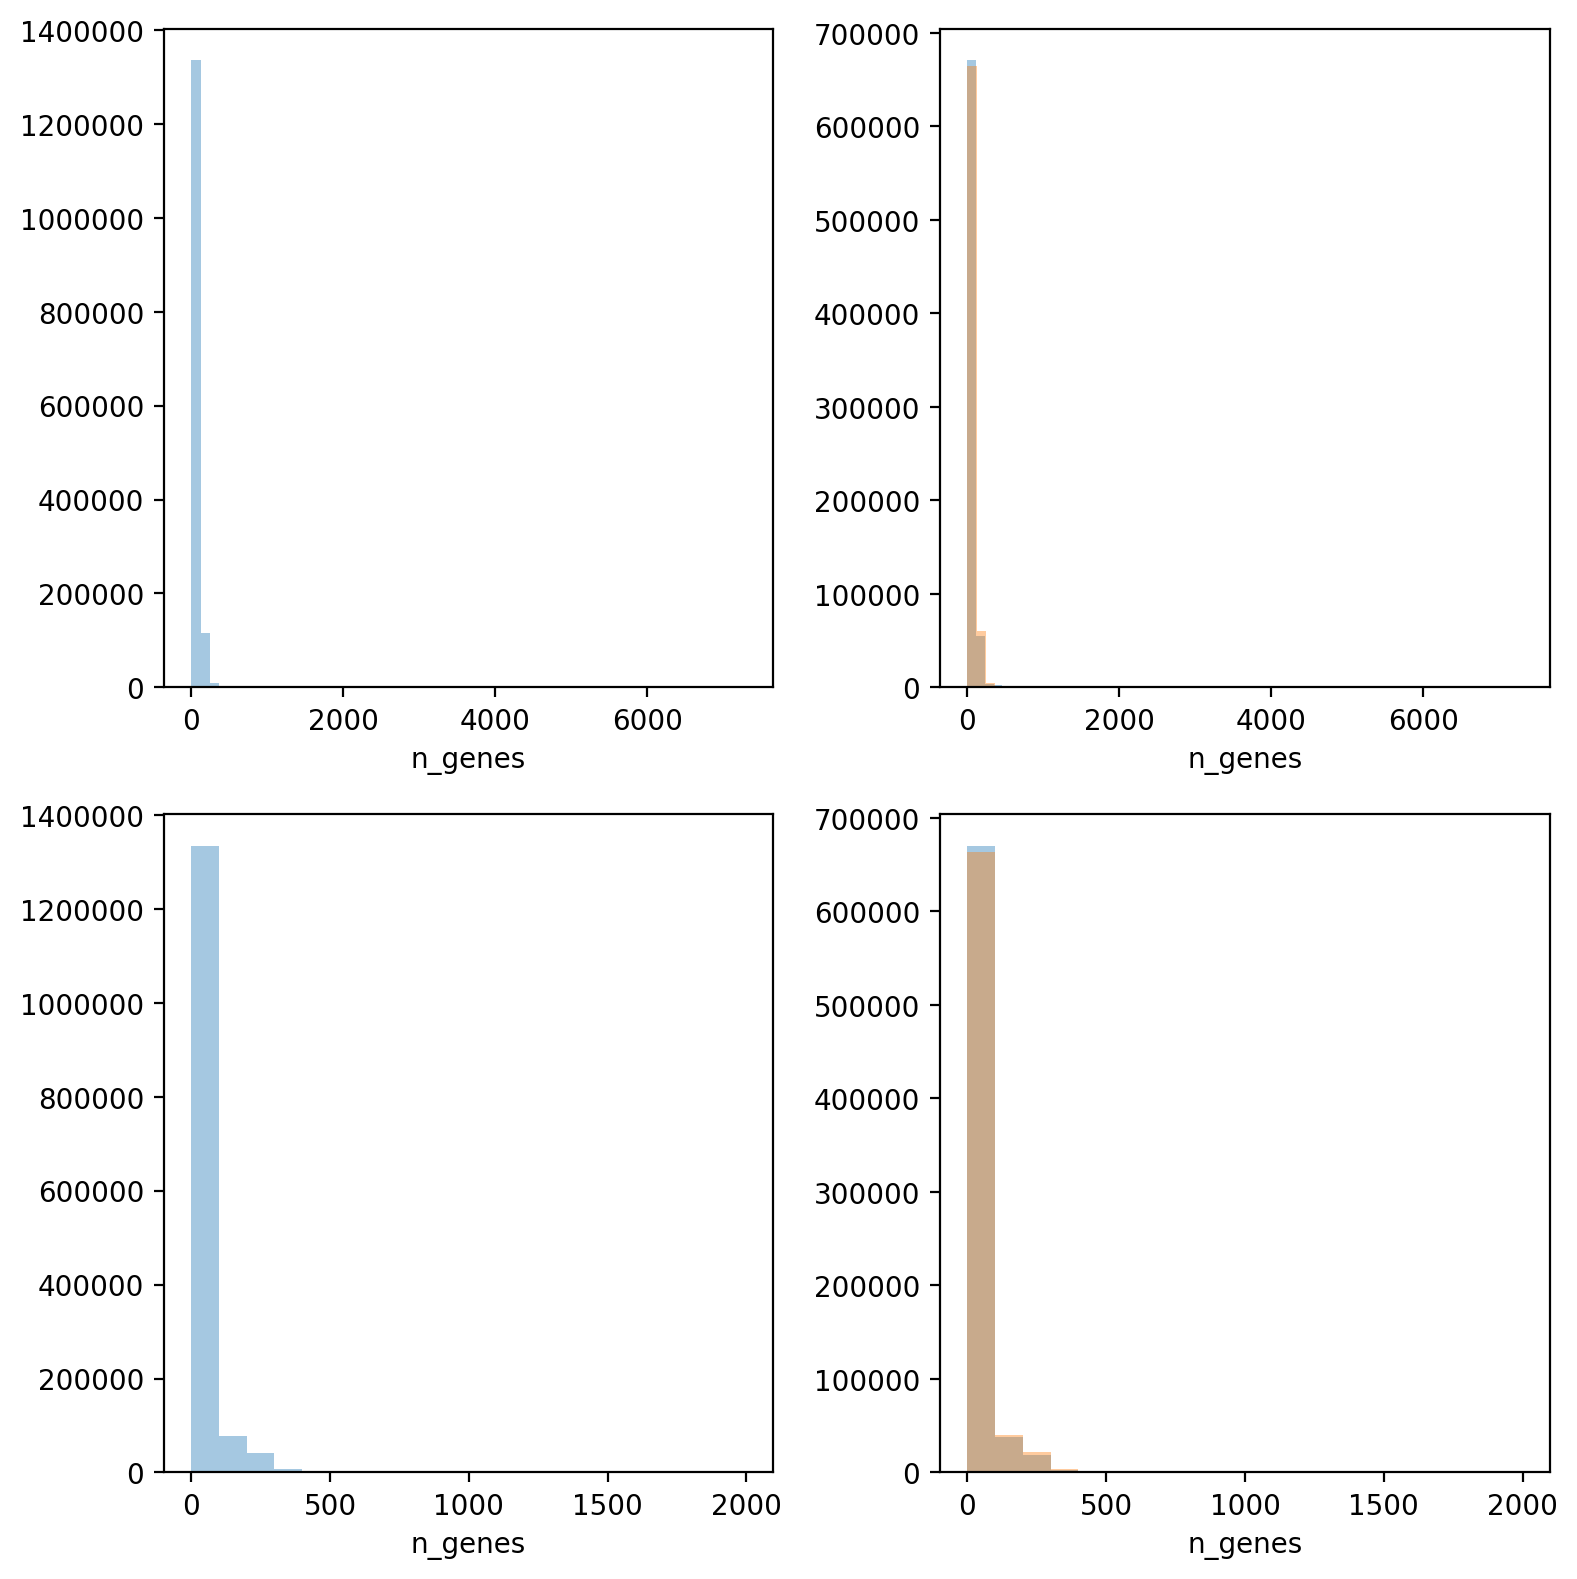

In [11]:
#Thresholding decision: genes
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sns.distplot(adata.obs['n_genes'], kde=False, bins=60, ax=ax[0, 0])
sns.distplot(adata.obs['n_genes'][adata.obs['condition']=='Control'], kde=False, bins=60, ax=ax[0, 1])
sns.distplot(adata.obs['n_genes'][adata.obs['condition']=='Stress'], kde=False, bins=60, ax=ax[0, 1])

sns.distplot(adata.obs['n_genes'][adata.obs['n_genes']<2000], kde=False, bins=20, ax=ax[1, 0])
sns.distplot(adata.obs['n_genes'][adata.obs['condition']=='Control'][adata.obs['n_genes']<2000], kde=False, bins=20, ax=ax[1, 1])
sns.distplot(adata.obs['n_genes'][adata.obs['condition']=='Stress'][adata.obs['n_genes']<2000], kde=False, bins=20, ax=ax[1, 1])
fig.tight_layout()

In [12]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 600)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 300)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

Total number of cells: 1474560
filtered out 25376 cells that havemore than 600 counts
Number of cells after min count filter: 1449184
filtered out 1336141 cells that haveless than 300 counts
Number of cells after min count filter: 113043


In [13]:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 27998
filtered out 14221 genes that are detectedin less than 20 cells
Number of genes after cell filter: 13777


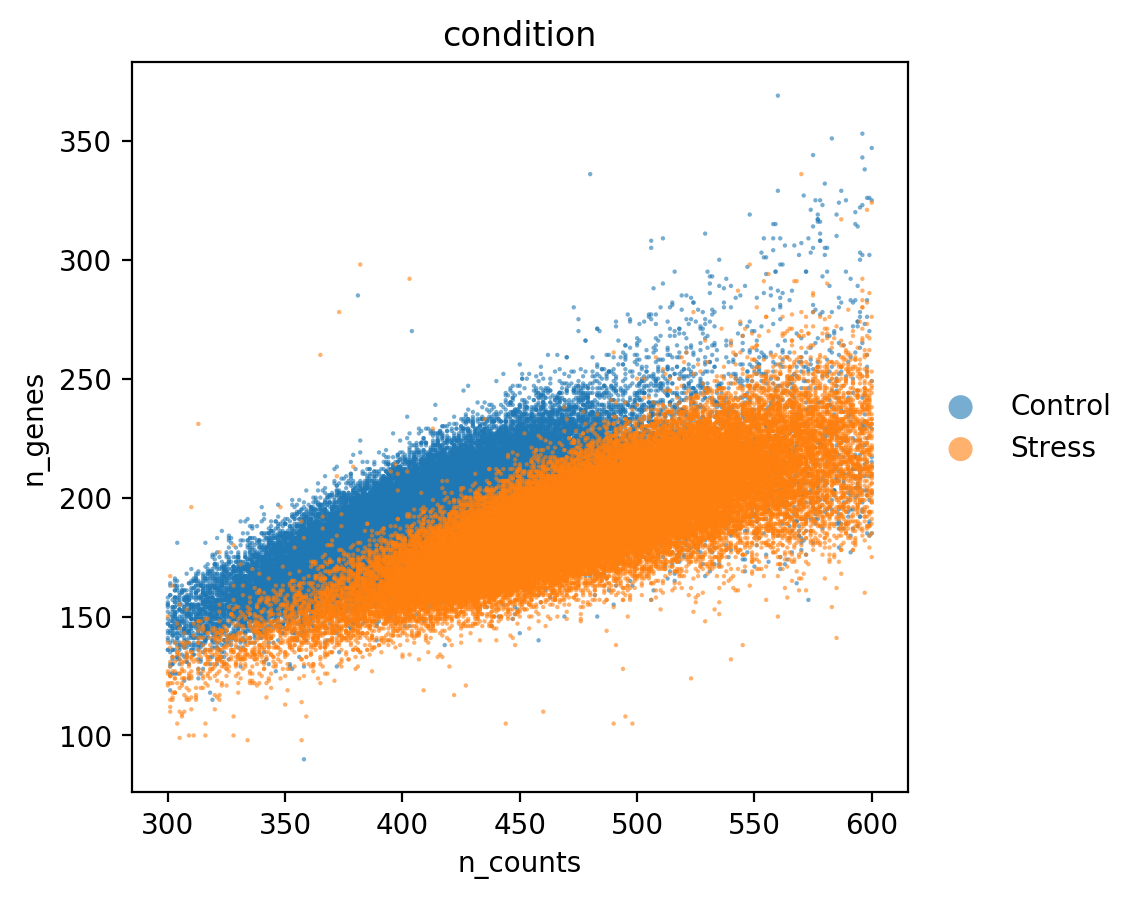

In [14]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', size=10, color='condition', alpha=0.6)
#p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac', size=10, alpha=0.6)

In [15]:
sc.pp.normalize_per_cell(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [16]:
sc.pp.log1p(adata)

In [17]:
adata.raw = adata

In [18]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=2000, subset=True)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 2000


In [19]:
from rpy2 import robjects
def mast_de_bulk(adata, save):
    '''Compute differential expression with the MAST package by treatment covariate on the whole dataset'''
    
    #if groupby not in ['louvain_final', 'louvain_three']:
    #    raise NotImplementedError("This function is only implemented to be used with 'louvain_final' and 'louvain_three' group labels")
    
    # Define R function to run MAST analysis
    robjects.r('''
        mast_de_r <- function(adata, obs, var){
            #Prepare data sets for SingleCellExperiment data structure conversion
            #obs['wellKey'] = row.names(obs)
            #var['primerid'] = row.names(var)
            print('Deploying to R...')
            #Convert to SingleCellExperiment type
            #sca <- FromMatrix(exprsArray=data_mat, fData=var)
            sca <- SceToSingleCellAssay(adata, class = "SingleCellAssay")
            #Compute Gene detection rate
            colData(sca)$n_genes = scale(colData(sca)$n_genes)

            #Create a vector that will hold all the DE results

            count <- 0
            print('Begin computation...')
            #Define & run hurdle model
            zlmCond <- zlm(formula = ~condition + n_genes, sca=sca)
            summaryCond <- summary(zlmCond, doLRT='conditionStress')
            summaryDt <- summaryCond$datatable
            
            result <- merge(summaryDt[contrast=='conditionStress' & component=='H',.(primerid, `Pr(>Chisq)`)], #p-vals
                             summaryDt[contrast=='conditionStress' & component=='logFC', .(primerid, coef)], #logFC coefficients
                             by='primerid') 
                             
            #Correct for multiple testing (FDR correction) and filtering
            result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
            result[,coef:=result[,coef]/log(2)]
            names(result) <- c("gene", "pval", "log2FC", "qval")
            result = result[order(result$qval),]
            output <- result
                
            return(output)
        }
    ''')
    
    mast_de = robjects.globalenv['mast_de_r']
    

    
    #Create new Anndata object for use in MAST with non-batch corrected data as before
    adata_test = adata.copy()
    adata_test.X = adata.raw.X
    adata_test.obs['n_genes'] = (adata_test.X > 0).sum(1) 
    
    obs = adata_test.obs
    var = adata_test.var
    
    expr_dict = {adata_test.var.index[i]:{} for i in range(adata_test.shape[1])}
    expr_dict_stress = {adata_test.var.index[i]:{} for i in range(adata_test.shape[1])}
    expr_dict_ctrl = {adata_test.var.index[i]:{} for i in range(adata_test.shape[1])}
    expr = np.asarray(np.mean(adata_test.X, axis=0)).flatten()
    print(expr.shape)
    expr_stress = np.asarray(np.mean(adata_test[(adata_test.obs['condition']=='Stress')].X, axis=0)).flatten()
    expr_ctrl = np.asarray(np.mean(adata_test[(adata_test.obs['condition']=='Control')].X, axis=0)).flatten()
    for i, gene in enumerate(adata_test.var.index):
        expr_dict[gene] = expr[i]
        expr_dict_stress[gene] = expr_stress[i]
        expr_dict_ctrl[gene] = expr_ctrl[i]
    
    result = mast_de(adata_test, obs, var)
    result
    writer = pd.ExcelWriter(save, engine='xlsxwriter')  
    result['meanExpr'] = [expr_dict[gene] for gene in result['gene'].values]
    result['meanExprStress'] = [expr_dict_stress[gene] for gene in result['gene'].values]
    result['meanExprCtrl'] = [expr_dict_ctrl[gene] for gene in result['gene'].values]
    result.to_excel(writer)

    writer.save()

    return result

In [20]:
adata.raw = adata

In [21]:
de_bulk = mast_de_bulk(adata, save='./results/de_pituitary_ambient_.xlsx')

(2000,)
[1] "Deploying to R..."
[1] "Begin computation..."


In [24]:
adata_filtered = sc.read('./results/adata_pituitary_batchcorr_renamed.h5ad')

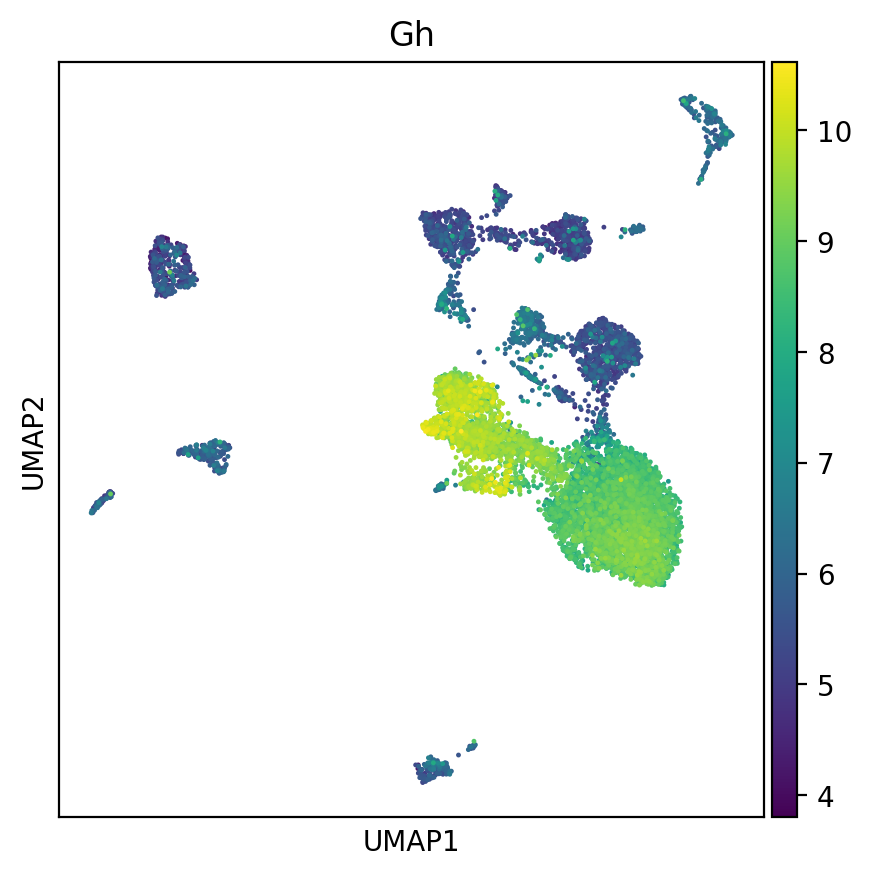

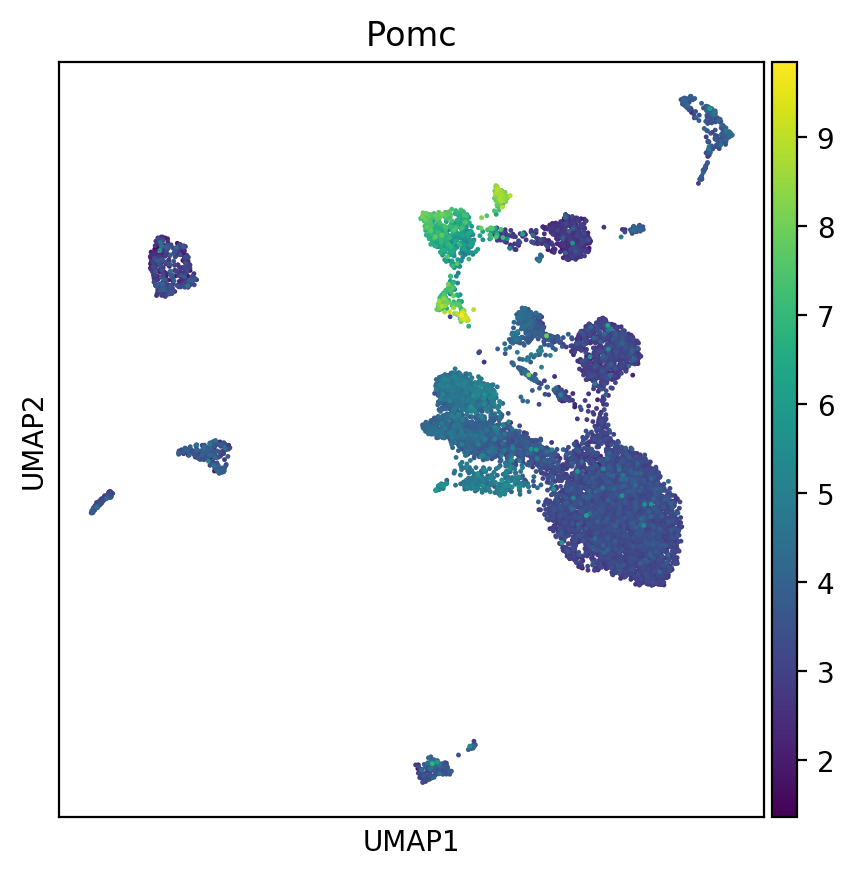

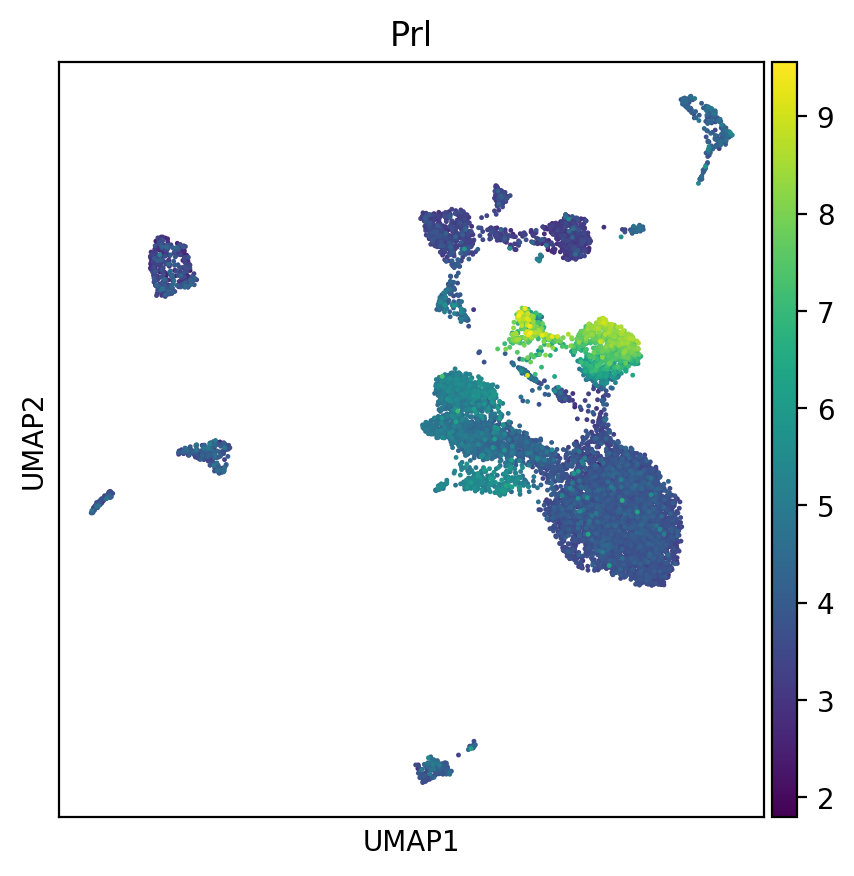

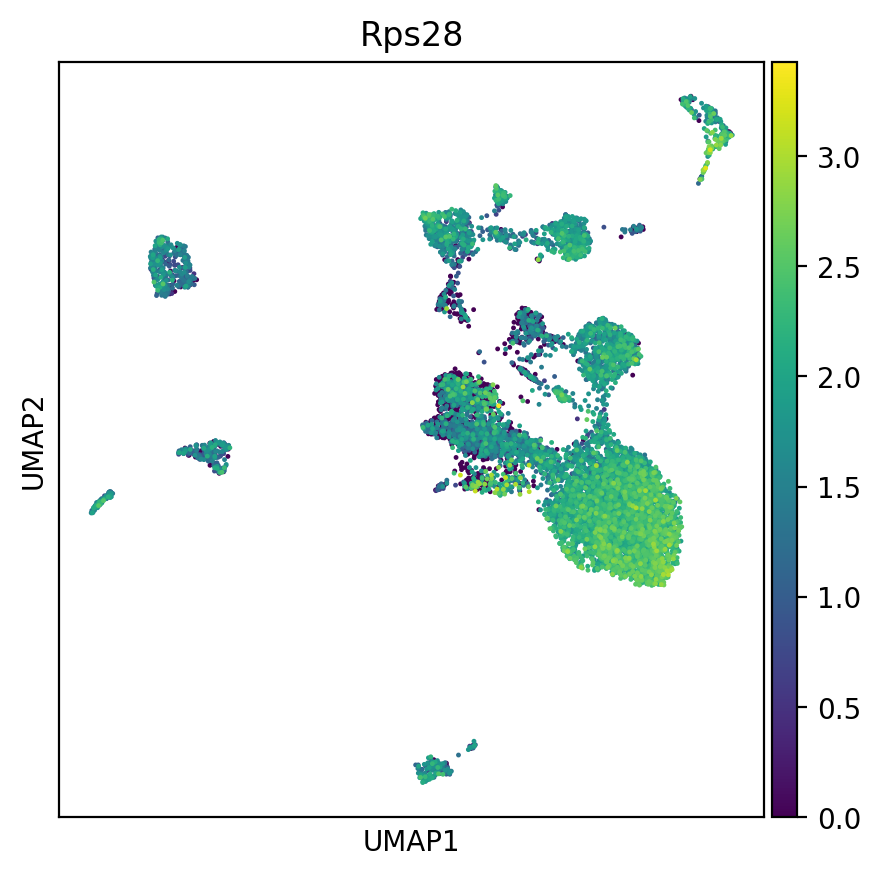

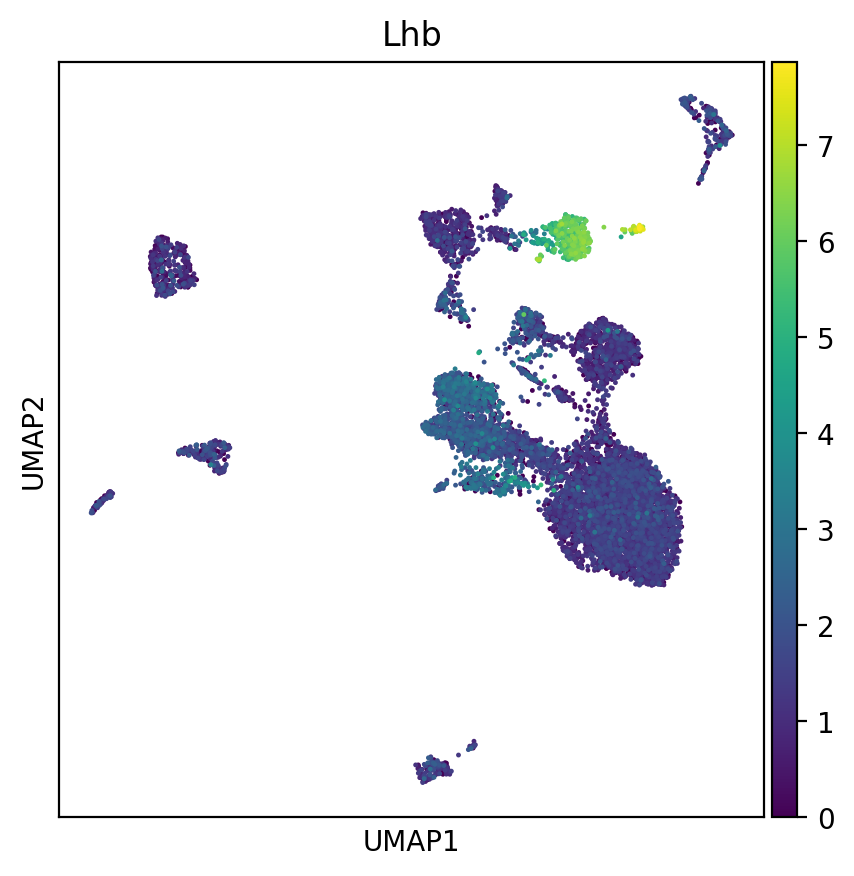

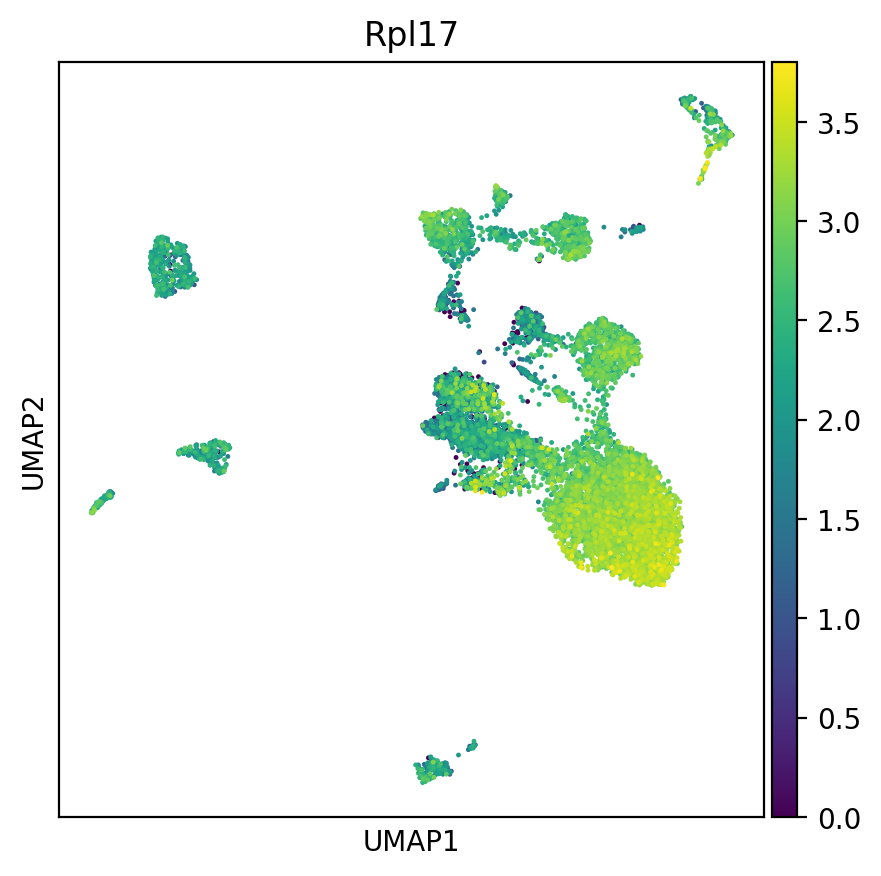

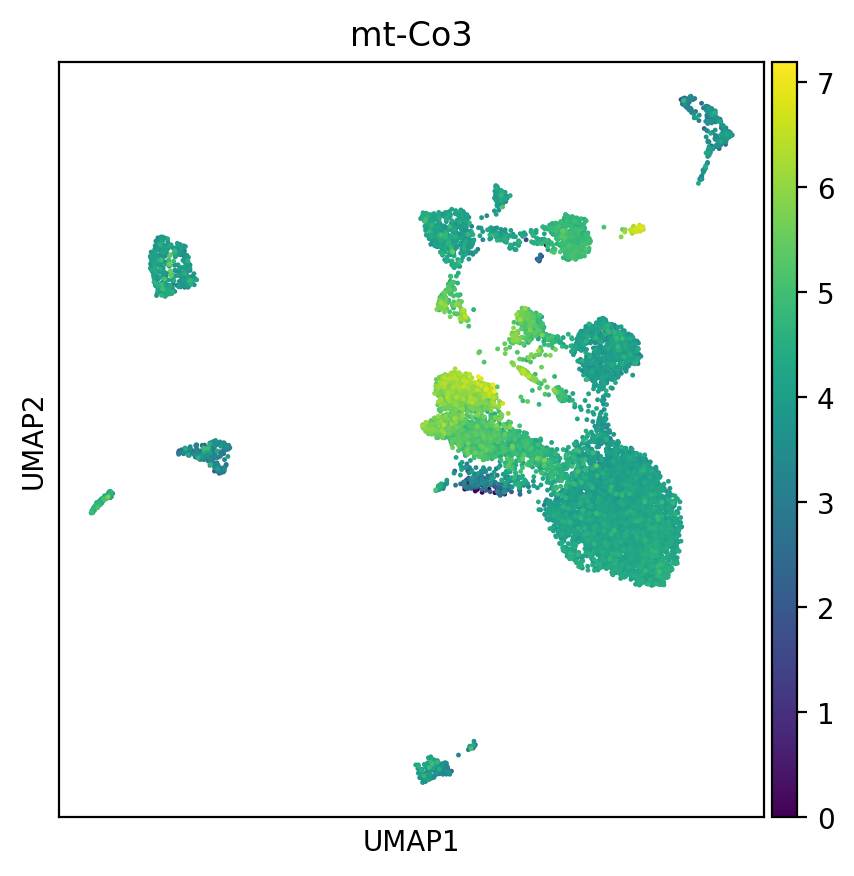

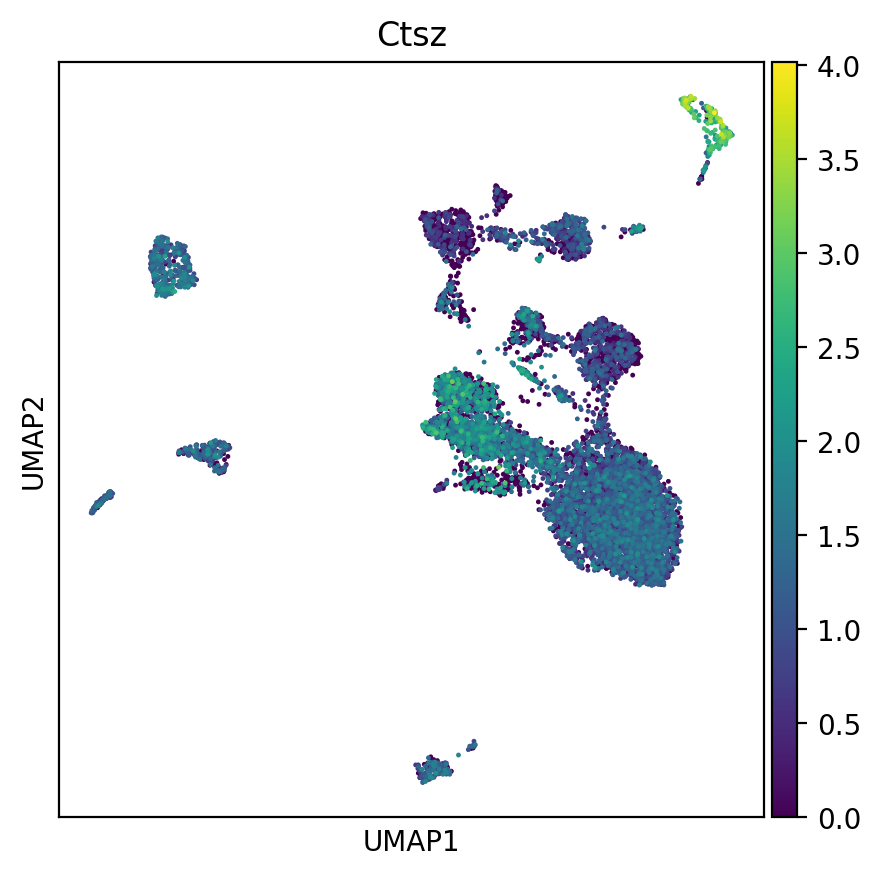

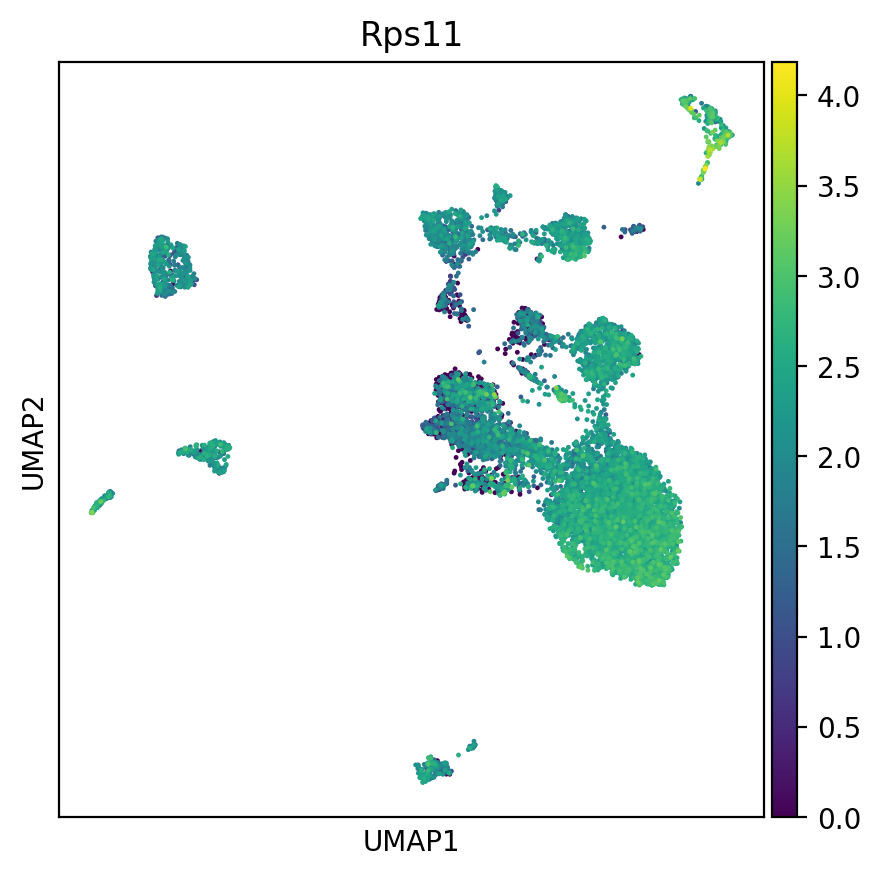

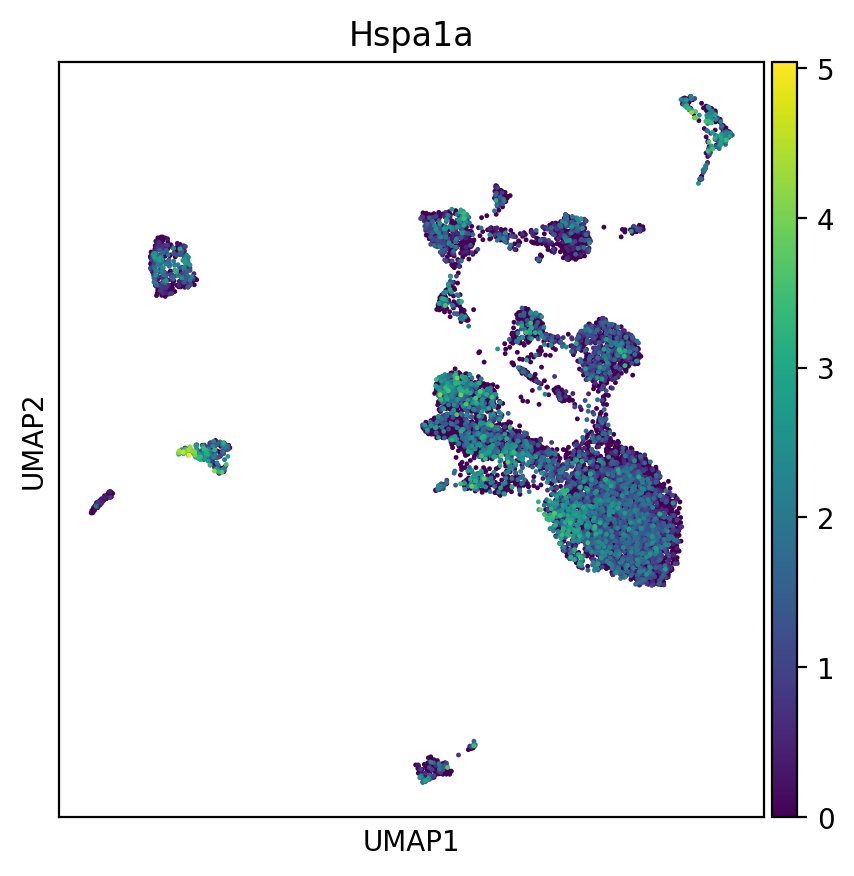

In [25]:
genes = de_bulk['gene'][:10]
for gene in genes:
    sc.pl.umap(adata_filtered, color=gene, save='_ambient_pituitary_' + gene + '.png')